In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [4]:
from torchvision import datasets, transforms

# すでに展開済みのCIFAR-10データの保存先を明示
data_path = "../data-unversioned/p1ch7"

# download=False にして、既存データを使う
cifar10 = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [6]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [7]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

In [8]:
numel_list = [
    p.numel()  # 各パラメータテンソルの要素数（たとえば重み行列の総数）
    for p in connected_model.parameters()  # 全てのパラメータをループ
    if p.requires_grad == True  # 勾配計算対象（学習対象）パラメータのみ
]

sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [9]:
first_model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

In [10]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [11]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [12]:
# 畳み込み層（Conv2d）を定義する
# 入力チャンネル数: 3（例：RGB画像）
# 出力チャンネル数: 16（16個の畳み込みフィルターを使用）
# カーネルサイズ: 3（3x3の畳み込みフィルター）
# ストライド: デフォルトは1（1ピクセルずつスライド）
# パディング: デフォルトは0（ゼロパディングなし）
# バイアス: デフォルトでTrue（各出力チャンネルにバイアス項あり）
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)

# 層の構成情報を出力（確認用）
print(conv)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))


In [13]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [14]:
# cifar2 データセットから1枚目の画像とラベルを取得（ここではラベルは使用しない）
img, _ = cifar2[0]

# Conv2d層は入力にミニバッチ次元が必要なため、unsqueeze(0) で1つ次元を追加して [1, 3, 32, 32] に変換
# img の元の形状は [3, 32, 32]（チャンネル, 高さ, 幅）
output = conv(img.unsqueeze(0))

# 入力画像の shape（[1, 3, 32, 32]）と、conv を通した出力の shape を表示
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

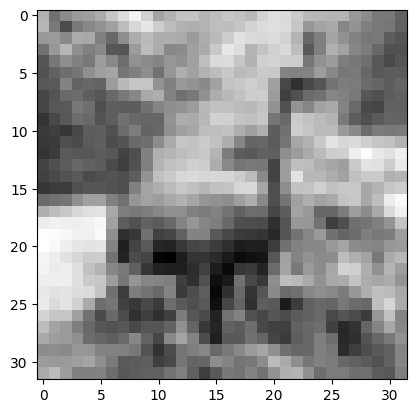

In [15]:
plt.imshow(img.mean(0), cmap="gray")
plt.show()

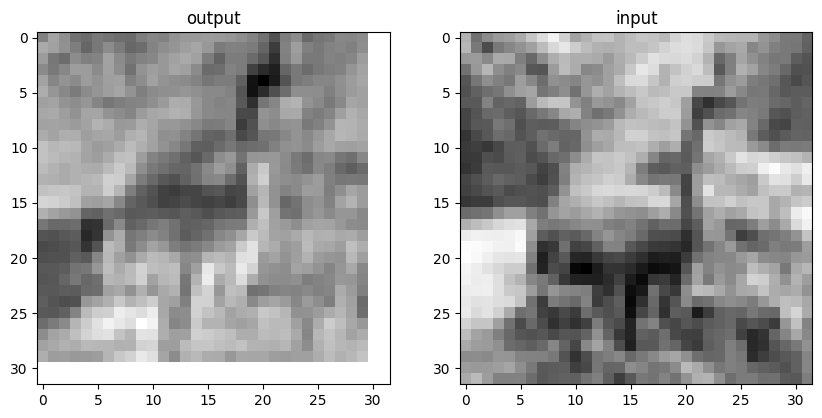

In [16]:
# 出力と入力画像を並べて比較するためのプロット設定（横2枚）
plt.figure(figsize=(10, 4.8))  # 図全体のサイズを設定（本では省略されている）

# 左側に出力特徴マップ（Conv2Dの出力）を表示
ax1 = plt.subplot(1, 2, 1)  # 左側のサブプロット（1行2列の1つ目）
plt.title("output")  # タイトルを設定
plt.imshow(
    output[0, 0].detach(), cmap="gray"
)  # バッチ0・チャネル0の出力をグレースケールで表示（detachで計算グラフから切り離し）

# 右側に元の入力画像（平均化したもの）を表示
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 左とx, y軸を共有
plt.imshow(
    img.mean(0), cmap="gray"
)  # 入力画像をチャネル方向に平均してグレースケール表示
plt.title("input")  # タイトルを設定

# 図をPNG画像として保存（本では省略されている）
plt.savefig("Ch8_F2_PyTorch.png")

# 表示
plt.show()

In [17]:
# 入力チャネル3（RGB）、出力チャネル1、カーネルサイズ3x3、パディング1のConv2D層を定義
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)  # <1>

# CIFAR2の画像（3チャネルのTensor）をバッチ次元を加えて(1, 3, 32, 32)に変形してConv2Dに通す
output = conv(img.unsqueeze(0))

# 入力と出力のテンソルサイズを確認
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [18]:
# 勾配追跡を無効にしてバイアスを0に設定（手動で重みを初期化するため）
with torch.no_grad():
    conv.bias.zero_()  # バイアス項をすべて0に設定

# 勾配追跡を無効にしてカーネルの重みをすべて1/9に設定
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)  # 3x3平均化フィルタとして畳み込み層を構成

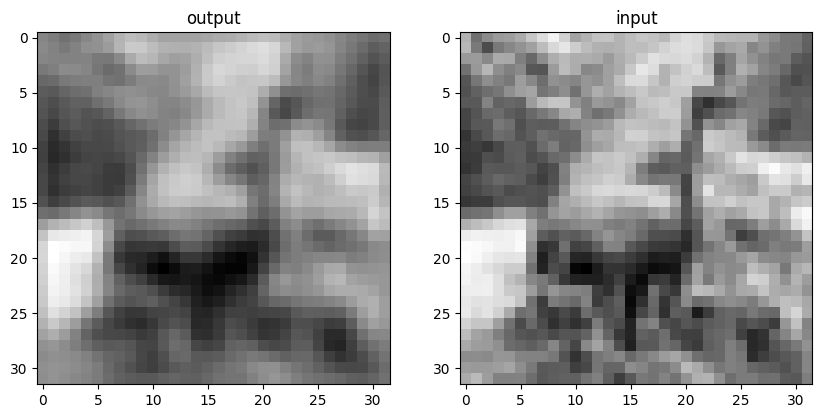

In [19]:
# 畳み込み演算を実行（画像テンソルを1つのバッチとして扱うためにunsqueeze(0)）
output = conv(img.unsqueeze(0))

# 図のサイズを設定
plt.figure(figsize=(10, 4.8))

# 左側：畳み込み後の出力を表示
ax1 = plt.subplot(1, 2, 1)
plt.title("output")
# 出力テンソルの1枚目のチャネル（グレースケール）を可視化
plt.imshow(output[0, 0].detach(), cmap="gray")

# 右側：元画像の平均（RGB→グレースケール相当）を表示
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title("input")
plt.imshow(img.mean(0), cmap="gray")

# 画像として保存（省略可能）
plt.savefig("Ch8_F4_PyTorch.png")

# 描画
plt.show()

In [20]:
# 3チャネル入力（RGB）に対し、1チャネル出力の畳み込み層を定義
# カーネルサイズは3x3、padding=1により出力サイズは入力と同じになる
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)

with torch.no_grad():
    # Sobelフィルタのようなエッジ検出カーネル（横方向の変化を検出）
    # conv.weight は shape (1, 3, 3, 3) なので、各チャネルに同じカーネルを設定する必要がある
    kernel = torch.tensor([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]])

    # conv.weight[0] の形状は (3, 3, 3)：RGBの各チャネルに対応
    # 全チャネルに同じカーネルをコピーすることで、RGBの変化を統合して検出
    for c in range(3):
        conv.weight[0, c] = kernel

    # バイアスをゼロに初期化（エッジ検出においてバイアスは不要）
    conv.bias.zero_()

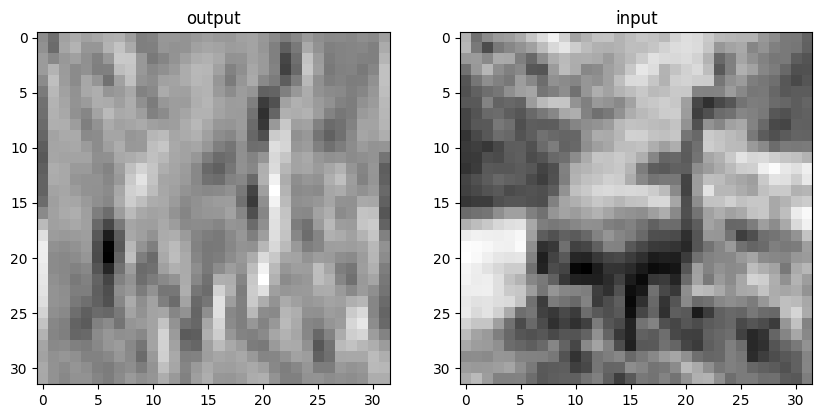

In [21]:
# conv層を通した画像（エッジ検出された画像）を取得
# img.unsqueeze(0): バッチ次元を追加し、(C, H, W) → (1, C, H, W) に変換
output = conv(img.unsqueeze(0))

# 図のサイズを指定（横長）
plt.figure(figsize=(10, 4.8))

# 左側に出力画像（エッジ検出結果）を表示
ax1 = plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.title("output")  # タイトルを設定
plt.imshow(output[0, 0].detach(), cmap="gray")  # 1チャネルの画像として表示

# 右側に元画像のグレースケール版（平均）を表示（比較のため）
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 左と同じサイズ軸で並べる
plt.imshow(img.mean(0), cmap="gray")  # RGBの平均値をグレースケールとして表示
plt.title("input")  # タイトルを設定

# 結果をファイルに保存（PNG形式）
plt.savefig("Ch8_F5_PyTorch.png")

# 画面にプロットを表示
plt.show()

In [22]:
# 2×2 の最大値プーリング層（MaxPooling）を定義
pool = nn.MaxPool2d(2)

# img: 形状 (3, 32, 32) の画像（チャネル数=3、縦32、横32）
# unsqueeze(0): バッチ次元を追加して (1, 3, 32, 32) に変換
output = pool(img.unsqueeze(0))  # プーリングを適用

# 入力画像と出力画像の形状を確認
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [23]:
# 畳み込みニューラルネットワーク（CNN）モデルを構築
model = nn.Sequential(
    # 入力: RGB画像（チャネル数3） → 出力: 16チャネル
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.Tanh(),  # 非線形活性化関数（tanh）
    nn.MaxPool2d(kernel_size=2),  # 空間解像度を1/2に（32×32 → 16×16）
    # 入力: 16チャネル → 出力: 8チャネル
    nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
    nn.Tanh(),  # 活性化関数
    nn.MaxPool2d(kernel_size=2),  # 空間解像度をさらに1/2（16×16 → 8×8）
    # ↓ここに全結合層などが続く予定（略）
    # nn.Flatten(),
    # nn.Linear(...),
    # ...
)

In [24]:
# CIFAR-10画像（3チャネル・32x32ピクセル）を入力とするCNNモデル
model = nn.Sequential(
    # 畳み込み層1：入力3チャネル → 出力16チャネル（カーネル3x3, padding=1）
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.Tanh(),  # 活性化関数（双曲線正接関数）
    # プーリング層1：2x2の最大プーリング（空間サイズを半分に）
    nn.MaxPool2d(kernel_size=2),  # 出力サイズ：16チャネル × 16 × 16
    # 畳み込み層2：16チャネル → 8チャネル（同様に3x3カーネル）
    nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
    nn.Tanh(),  # 活性化関数
    # プーリング層2：再度2x2プーリング（空間サイズを半分に）
    nn.MaxPool2d(kernel_size=2),  # 出力サイズ：8チャネル × 8 × 8
    # 全結合層への接続（8*8*8 = 512 次元ベクトルをFlattenして線形変換）
    nn.Flatten(),  # 出力を1次元に展開（バッチサイズ, 512）
    nn.Linear(in_features=8 * 8 * 8, out_features=32),  # 隠れ層（32ユニット）
    nn.Tanh(),  # 活性化関数
    # 出力層：2クラス分類用（例：airplane vs bird）
    nn.Linear(in_features=32, out_features=2),  # 最終出力（ロジット）
)

In [25]:
# 各パラメータの要素数（numel）をリストとして取得
numel_list = [p.numel() for p in model.parameters()]

# 総パラメータ数と、各層のパラメータ数の一覧を表示
total_params = sum(numel_list)
total_params, numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
# 画像テンソル `img` をバッチサイズ次元を加えて [1, 3, 32, 32] の形に変形
# モデルに1枚の画像を入力し、出力（分類スコアなど）を得る
output = model(img.unsqueeze(0))

In [27]:
# 畳み込みニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 入力チャンネル3（RGB画像）→出力チャンネル16、3x3カーネル、パディング1（出力サイズ保持）
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)

        # 活性化関数 Tanh（非線形変換）
        self.act1 = nn.Tanh()

        # 2x2の最大プーリング（画像サイズを1/2に）
        self.pool1 = nn.MaxPool2d(2)

        # conv1の出力16チャネル→8チャネルに縮小、再度3x3カーネル
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)

        # 全結合層1：8チャネル × 8ピクセル × 8ピクセル → 32次元に変換
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()

        # 全結合層2：32次元 → 出力クラス数（ここでは2クラス）
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # conv1 → Tanh → MaxPool
        out = self.pool1(self.act1(self.conv1(x)))

        # conv2 → Tanh → MaxPool
        out = self.pool2(self.act2(self.conv2(out)))

        # 2次元の画像データを1次元ベクトルに変換
        # バッチサイズ × 特徴数（8チャネル × 8 × 8 = 512）
        out = out.view(-1, 8 * 8 * 8)  # <1>

        # 全結合層 → Tanh
        out = self.act3(self.fc1(out))

        # 最終出力層（クラススコア）
        out = self.fc2(out)

        return out

In [28]:
model = Net()  # モデルのインスタンス化

# 各パラメータ（重み・バイアス）の要素数をリスト化し、合計を算出
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [29]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 入力: RGB画像 (3チャネル)
        # 出力: 16チャネルの特徴マップ（カーネルサイズ3x3, パディング1で画像サイズ維持）
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)

        # 入力: 16チャネル → 出力: 8チャネル
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        # 全結合層1：8×8×8=512ユニット → 32ユニットへ圧縮
        self.fc1 = nn.Linear(8 * 8 * 8, 32)

        # 全結合層2：32ユニット → クラス数2（分類）
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 第1畳み込み → tanh活性化関数 → 2×2の最大プーリング
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)

        # 第2畳み込み → tanh活性化関数 → 2×2の最大プーリング
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)

        # バッチサイズを維持したままテンソルをフラット化（shape: [batch_size, 512]）
        out = out.view(-1, 8 * 8 * 8)

        # 全結合層1 → tanh活性化関数
        out = torch.tanh(self.fc1(out))

        # 全結合層2（出力層）：分類結果のスコア（softmax/logsoftmaxは後段で適用）
        out = self.fc2(out)

        return out

In [30]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward0>)

In [32]:
import datetime


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(
                "{} Epoch {}, Training loss {:.4f}".format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)
                )
            )

In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)  # <1>

model = Net()  # <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  # <3>
loss_fn = nn.CrossEntropyLoss()  # <4>

training_loop(  # <5>
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

# <1>
# cifar2（airplaneとbirdの2クラス）のデータセットをDataLoaderでラップする。
# これにより、64枚ずつのバッチでモデルに渡せるようになり、学習が高速化される。
# shuffle=True により、毎エポックごとにデータの順序をランダムにする。
# これにより、学習が偏らず汎化性能が高まる。

# <2>
# 自作の畳み込みニューラルネットワーク Net クラスをインスタンス化し、
# 学習対象のモデルとして準備する。

# <3>
# 学習には確率的勾配降下法（SGD）を使用し、学習率は 1e-2（0.01）に設定する。
# optimizer は、model.parameters()（学習可能パラメータ）を対象に更新を行う。

# <4>
# 分類問題に広く使われるクロスエントロピー損失関数を使用。
# モデルの出力が生のロジットである必要がある（LogSoftmax は不要）。

# <5>
# 事前に定義した training_loop 関数を使ってモデルを訓練する。
# 引数には、エポック数、最適化手法、モデル本体、損失関数、訓練データローダーを渡す。

2025-08-07 16:26:08.848026 Epoch 1, Training loss 0.6205
2025-08-07 16:26:37.666253 Epoch 10, Training loss 0.3409
2025-08-07 16:27:08.397993 Epoch 20, Training loss 0.3016
2025-08-07 16:27:38.182824 Epoch 30, Training loss 0.2756
2025-08-07 16:28:09.647475 Epoch 40, Training loss 0.2557
2025-08-07 16:28:43.913909 Epoch 50, Training loss 0.2359
2025-08-07 16:29:15.976953 Epoch 60, Training loss 0.2203
2025-08-07 16:29:46.911262 Epoch 70, Training loss 0.2042
2025-08-07 16:30:16.785676 Epoch 80, Training loss 0.1906
2025-08-07 16:30:47.904803 Epoch 90, Training loss 0.1763
2025-08-07 16:31:17.179095 Epoch 100, Training loss 0.1639


In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)


def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1> 勾配計算を無効化（評価時は学習しないため不要）
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(
                    outputs, dim=1
                )  # <2> 最も高いスコアのインデックス（クラス）を取得
                total += labels.shape[0]  # <3> バッチ内のサンプル数を加算
                correct += int(
                    (predicted == labels).sum()
                )  # <4> 正解数を加算（Bool配列をintへ）

        print("Accuracy {}: {:.2f}".format(name, correct / total))


validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.90


In [35]:
torch.save(model.state_dict(), data_path + "birds_vs_airplanes.pt")

In [36]:
# モデルのインスタンスを生成する
loaded_model = Net()  # <1>

# 保存しておいたモデルの学習済みパラメータ（state_dict）を読み込む
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt"))

# <1>
# 注意：モデル定義（クラス Net）の構造が保存時と一致している必要がある。
# 例えばレイヤーの数や順番が異なると、読み込み時にエラーとなる。

<All keys matched successfully>

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training on device {device}.")

Training on device cpu.


In [43]:
# モデルの学習・推論に使用するデバイスを自動で選択
# 優先順位: CUDA(GPU) > MPS(MacのMetal) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# 選択されたデバイスを表示
print(f"Training on device {device}.")

Training on device mps.


In [44]:
import datetime


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0  # 各エポックの累積損失を初期化

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1> 入力画像を指定デバイス（GPU/CPU）に転送
            labels = labels.to(device=device)  # 正解ラベルも同じデバイスに転送

            outputs = model(imgs)  # モデルに画像を入力して出力（予測値）を得る
            loss = loss_fn(outputs, labels)  # 出力と正解ラベルから損失を計算

            optimizer.zero_grad()  # 前回の勾配情報をリセット
            loss.backward()  # 誤差逆伝播で各パラメータの勾配を計算
            optimizer.step()  # 勾配を使ってパラメータを更新

            loss_train += loss.item()  # バッチごとの損失を加算（float化）

        # 初回または10エポックごとに損失の平均を表示
        if epoch == 1 or epoch % 10 == 0:
            print(
                "{} Epoch {}, Training loss {:.4f}".format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)
                )
            )

In [45]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size=64, shuffle=True
)  # DataLoaderでデータを64枚ずつのバッチにまとめ、順番をシャッフル

model = Net().to(
    device=device
)  # <1> ネットワークを生成し、指定デバイス（GPU/CPU）に転送
optimizer = optim.SGD(
    model.parameters(), lr=1e-2
)  # SGD（確率的勾配降下法）で学習率1e-2を設定
loss_fn = nn.CrossEntropyLoss()  # 多クラス分類用の損失関数（交差エントロピー損失）

# 学習ループを呼び出し、100エポック分の学習を実行
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2025-08-08 19:12:39.772938 Epoch 1, Training loss 0.5724
2025-08-08 19:12:47.762502 Epoch 10, Training loss 0.3307
2025-08-08 19:12:56.285359 Epoch 20, Training loss 0.2915
2025-08-08 19:13:04.418745 Epoch 30, Training loss 0.2655
2025-08-08 19:13:12.623989 Epoch 40, Training loss 0.2490
2025-08-08 19:13:20.737307 Epoch 50, Training loss 0.2325
2025-08-08 19:13:28.850945 Epoch 60, Training loss 0.2179
2025-08-08 19:13:37.096760 Epoch 70, Training loss 0.1981
2025-08-08 19:13:45.327588 Epoch 80, Training loss 0.1868
2025-08-08 19:13:53.421773 Epoch 90, Training loss 0.1708
2025-08-08 19:14:01.819875 Epoch 100, Training loss 0.1551


In [46]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size=64, shuffle=False
)  # 訓練データを64枚ずつのバッチにまとめ、順番は固定
val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size=64, shuffle=False
)  # 検証データも同様にバッチ化、順序固定

all_acc_dict = collections.OrderedDict()  # 評価結果を記録するための順序付き辞書


def validate(model, train_loader, val_loader):
    """
    モデルの訓練データおよび検証データに対する精度を計算する関数
    """
    accdict = {}  # 結果を格納する辞書
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0  # 正解数
        total = 0  # サンプル総数

        with torch.no_grad():  # 評価時は勾配計算不要
            for imgs, labels in loader:
                imgs = imgs.to(device=device)  # 入力データをGPU/CPUへ転送
                labels = labels.to(device=device)  # ラベルも転送
                outputs = model(imgs)  # モデルによる予測
                _, predicted = torch.max(
                    outputs, dim=1
                )  # <1> 出力の最大値インデックス（予測クラス）を取得
                total += labels.shape[0]  # バッチサイズを加算
                correct += int((predicted == labels).sum())  # 一致した予測数を加算

        print("Accuracy {}: {:.2f}".format(name, correct / total))
        accdict[name] = correct / total  # 訓練・検証ごとの精度を記録
    return accdict


# ベースラインモデルの精度を計算して記録
all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


In [47]:
# 保存済みモデルの読み込み
loaded_model = Net().to(device=device)  # モデル構造をインスタンス化し、GPU/CPUへ転送
loaded_model.load_state_dict(
    torch.load(
        data_path + "birds_vs_airplanes.pt",  # 学習済みパラメータファイルのパス
        map_location=device,  # 保存時と異なる環境（CPU/GPU）でも読み込めるようにマッピング
    )
)

<All keys matched successfully>

In [48]:
# 幅（チャンネル数）を増やしたCNNである。
# conv1を16→32チャネル、conv2を8→16チャネルに拡張し、特徴表現の容量を上げる設計である。
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        # 入力3チャネル(RGB) → 32チャネルへ。kernel=3, padding=1 により空間サイズは保持される(32x32 → 32x32)である。
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # 32チャネル → 16チャネルへ。ここでも空間サイズは保持される。
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        # プーリング2回で空間は 32→16→8 に縮小されるため、特徴マップは (16, 8, 8) となる。
        # よって全結合の入力次元は 16*8*8 = 1024 である。
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        # 出力は2クラスのスコア（ロジット）である。CrossEntropyLossと併用を想定するためSoftmaxは付けない。
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 第1畳み込み → tanh → 2x2 MaxPool（空間: 32→16）。出力形状は (B, 32, 16, 16) である。
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        # 第2畳み込み → tanh → 2x2 MaxPool（空間: 16→8）。出力形状は (B, 16, 8, 8) である。
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        # 全結合層に渡すためにフラット化する。形状は (B, 16*8*8) = (B, 1024) である。
        out = out.view(-1, 16 * 8 * 8)
        # 中間全結合 → tanh により非線形性を付与する。
        out = torch.tanh(self.fc1(out))
        # 最終全結合で2クラスのロジットを出力する。
        out = self.fc2(out)
        return out

In [49]:
# 幅を増やしたCNNモデルをデバイスへ転送し、最適化手法と損失関数を準備する。
model = NetWidth().to(device=device)  # モデル本体をGPU/MPS/CPUへ配置する。
optimizer = optim.SGD(
    model.parameters(), lr=1e-2
)  # 確率的勾配降下法（学習率1e-2）を用いる。
loss_fn = (
    nn.CrossEntropyLoss()
)  # 多クラス分類用の交差エントロピー損失である（ロジット入力前提）。

# 100エポック学習を実行する。training_loop内でデバイス転送・順伝播・損失計算・逆伝播・更新を行う。
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

# 評価時は学習挙動を固定するためevalモードへ（Dropout/BatchNormがある場合に効果あり）。
# 本モデルには該当層は無いが、評価の定石として明示しておく。
model.eval()  # 評価モードへ切替（勾配計算はvalidate内でno_grad指定済み）。
validate(
    model, train_loader, val_loader
)  # 訓練・検証データに対する正解率を算出・表示する。

2025-08-08 19:26:48.480187 Epoch 1, Training loss 0.5461
2025-08-08 19:26:59.186688 Epoch 10, Training loss 0.3223
2025-08-08 19:27:11.151542 Epoch 20, Training loss 0.2828
2025-08-08 19:27:23.434055 Epoch 30, Training loss 0.2501
2025-08-08 19:27:36.596970 Epoch 40, Training loss 0.2199
2025-08-08 19:27:50.067996 Epoch 50, Training loss 0.1936
2025-08-08 19:28:02.687765 Epoch 60, Training loss 0.1696
2025-08-08 19:28:15.894335 Epoch 70, Training loss 0.1468
2025-08-08 19:28:28.634432 Epoch 80, Training loss 0.1255
2025-08-08 19:28:41.354191 Epoch 90, Training loss 0.1060
2025-08-08 19:28:53.557957 Epoch 100, Training loss 0.0887
Accuracy train: 0.96
Accuracy val: 0.89


{'train': 0.9613, 'val': 0.8945}

In [50]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        # n_chans1: 1層目の畳み込み層の出力チャネル数（フィルタ数）を指定
        self.n_chans1 = n_chans1

        # 1層目の畳み込み層（入力3チャネル: RGB、出力n_chans1チャネル、3x3フィルタ、パディング1で空間サイズを維持）
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)

        # 2層目の畳み込み層（入力n_chans1チャネル、出力はその半分のチャネル数）
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)

        # 全結合層1（入力は8x8の特徴マップ×n_chans1//2チャネル → 出力32次元）
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)

        # 全結合層2（入力32次元 → 出力2クラス分類）
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 1層目: 畳み込み → Tanh活性化 → 2x2最大プーリングで空間サイズを半分に
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)

        # 2層目: 畳み込み → Tanh活性化 → 2x2最大プーリングでさらに空間サイズを半分に
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)

        # 全結合層に入力するため、(バッチサイズ, 特徴量数) にフラット化
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)

        # 全結合層1 → Tanh活性化
        out = torch.tanh(self.fc1(out))

        # 全結合層2（出力はロジット）
        out = self.fc2(out)
        return out

In [51]:
# モデルを初期化（n_chans1=32で幅を指定）
model = NetWidth(n_chans1=32).to(device=device)

# 最適化手法をSGD（確率的勾配降下法）で設定、学習率は0.01
optimizer = optim.SGD(model.parameters(), lr=1e-2)

# 損失関数にクロスエントロピー誤差を使用（分類問題向け）
loss_fn = nn.CrossEntropyLoss()

# 100エポック分、モデルの学習を実行
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

# 学習後のモデルを評価し、訓練セットと検証セットの精度を記録
all_acc_dict["width"] = validate(model, train_loader, val_loader)

2025-08-08 19:29:20.547302 Epoch 1, Training loss 0.5581
2025-08-08 19:29:32.243638 Epoch 10, Training loss 0.3256
2025-08-08 19:29:44.831507 Epoch 20, Training loss 0.2789
2025-08-08 19:29:57.634893 Epoch 30, Training loss 0.2461
2025-08-08 19:30:10.822411 Epoch 40, Training loss 0.2178
2025-08-08 19:30:23.697737 Epoch 50, Training loss 0.1909
2025-08-08 19:30:36.381581 Epoch 60, Training loss 0.1660
2025-08-08 19:30:49.113316 Epoch 70, Training loss 0.1429
2025-08-08 19:31:01.783578 Epoch 80, Training loss 0.1214
2025-08-08 19:31:14.390115 Epoch 90, Training loss 0.1016
2025-08-08 19:31:27.068262 Epoch 100, Training loss 0.0834
Accuracy train: 0.97
Accuracy val: 0.88


In [52]:
sum(p.numel() for p in model.parameters())

38386

In [53]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    """
    L2正則化（Weight Decay）を手動で加えた学習ループ
    """
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0  # 各エポックの累積損失を記録する変数

        # 学習データローダーからミニバッチを取り出す
        for imgs, labels in train_loader:
            # <GPU/MPS/CPU> にデータを転送
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # モデルの順伝播（予測値を計算）
            outputs = model(imgs)

            # 交差エントロピー損失を計算（分類タスク用）
            loss = loss_fn(outputs, labels)

            # ==========================
            # L2正則化項の追加処理
            # ==========================
            l2_lambda = 0.001  # 正則化の強さ（係数）
            # 全パラメータの二乗和を計算
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # <1>
            # 元の損失にL2正則化項を加算
            loss = loss + l2_lambda * l2_norm

            # 勾配を初期化（累積を防ぐ）
            optimizer.zero_grad()

            # 誤差逆伝播（各パラメータの勾配を計算）
            loss.backward()

            # パラメータの更新（SGDなど）
            optimizer.step()

            # ミニバッチ損失を加算（.item()でPythonのfloatに変換）
            loss_train += loss.item()

        # 進捗ログ（初回と10エポックごとに表示）
        if epoch == 1 or epoch % 10 == 0:
            print(
                "{} Epoch {}, Training loss {:.4f}".format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)
                )
            )  # バッチ平均の損失を出力

In [54]:
# モデルのインスタンスを生成し、指定されたデバイス（GPU/MPS/CPU）に転送
model = Net().to(device=device)

# 最適化手法として確率的勾配降下法（SGD）を設定
# model.parameters() は学習対象のパラメータを返す
# lr=1e-2 は学習率を 0.01 に設定
optimizer = optim.SGD(model.parameters(), lr=1e-2)

# 損失関数として交差エントロピー損失を設定
# 分類タスクでよく使われ、出力はSoftmax前のlogitを想定
loss_fn = nn.CrossEntropyLoss()

# 学習ループ（L2正則化あり）を実行
training_loop_l2reg(
    n_epochs=100,  # 学習エポック数
    optimizer=optimizer,  # 最適化関数
    model=model,  # 学習対象のモデル
    loss_fn=loss_fn,  # 損失関数
    train_loader=train_loader,  # 訓練データローダ
)

# 学習済みモデルを用いて訓練データと検証データの精度を計算
# validate関数は精度を計算し、辞書形式で返す
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2025-08-08 19:36:55.590722 Epoch 1, Training loss 0.6125
2025-08-08 19:37:05.782370 Epoch 10, Training loss 0.3482
2025-08-08 19:37:17.087890 Epoch 20, Training loss 0.3223
2025-08-08 19:37:28.642603 Epoch 30, Training loss 0.3048
2025-08-08 19:37:39.936260 Epoch 40, Training loss 0.2877
2025-08-08 19:37:51.223356 Epoch 50, Training loss 0.2721
2025-08-08 19:38:02.555364 Epoch 60, Training loss 0.2585
2025-08-08 19:38:15.200333 Epoch 70, Training loss 0.2467
2025-08-08 19:38:26.354619 Epoch 80, Training loss 0.2360
2025-08-08 19:38:37.788019 Epoch 90, Training loss 0.2263
2025-08-08 19:38:48.935163 Epoch 100, Training loss 0.2173
Accuracy train: 0.92
Accuracy val: 0.89


In [55]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1  # 最初の畳み込み層の出力チャネル数

        # --- 畳み込み層1 ---
        # 入力: RGB画像（3チャネル）
        # 出力: n_chans1 チャネルの特徴マップ
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)

        # ドロップアウト（2D版: 特徴マップ単位で無効化）
        # p=0.4 → 40% の特徴マップをランダムに無効化
        self.conv1_dropout = nn.Dropout2d(p=0.4)

        # --- 畳み込み層2 ---
        # 入力: n_chans1 チャネル
        # 出力: n_chans1 // 2 チャネル
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)

        # ドロップアウト（2D版）
        self.conv2_dropout = nn.Dropout2d(p=0.4)

        # --- 全結合層1 ---
        # 入力次元: 8×8の空間サイズ × (n_chans1 // 2) チャネル
        # 出力次元: 32
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)

        # --- 全結合層2 ---
        # 出力次元: 2クラス分類（例: 鳥 vs 飛行機）
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 畳み込み層1 → Tanh活性化 → 2×2のMaxPooling
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)

        # ドロップアウト（訓練時のみ有効）
        out = self.conv1_dropout(out)

        # 畳み込み層2 → Tanh活性化 → 2×2のMaxPooling
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)

        # ドロップアウト
        out = self.conv2_dropout(out)

        # 特徴マップをフラット化（バッチサイズ × 特徴次元）
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)

        # 全結合層1 → Tanh活性化
        out = torch.tanh(self.fc1(out))

        # 全結合層2（出力層: ロジット値）
        out = self.fc2(out)

        return out

In [56]:
# --- モデルの構築 ---
# NetDropout クラスをインスタンス化（n_chans1=32）し、
# 学習・推論を行うデバイス（CPU/GPU/MPS）へ転送
model = NetDropout(n_chans1=32).to(device=device)

# --- 最適化関数の設定 ---
# SGD（確率的勾配降下法）を使用し、学習率は 1e-2 に設定
optimizer = optim.SGD(model.parameters(), lr=1e-2)

# --- 損失関数の設定 ---
# 多クラス分類用の交差エントロピー損失を使用
loss_fn = nn.CrossEntropyLoss()

# --- モデルの訓練 ---
# 先に定義した training_loop 関数を使い、
# モデル・最適化関数・損失関数・訓練データローダーを指定
training_loop(
    n_epochs=100,  # 学習エポック数
    optimizer=optimizer,  # 最適化関数
    model=model,  # 学習対象モデル
    loss_fn=loss_fn,  # 損失関数
    train_loader=train_loader,  # 訓練用データローダー
)

# --- モデルの評価 ---
# 訓練データと検証データに対する分類精度を計測
# all_acc_dict に "dropout" というキーで結果を保存
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2025-08-08 19:47:09.495359 Epoch 1, Training loss 0.5867
2025-08-08 19:47:20.946929 Epoch 10, Training loss 0.3794
2025-08-08 19:47:34.123541 Epoch 20, Training loss 0.3561
2025-08-08 19:47:46.599883 Epoch 30, Training loss 0.3338
2025-08-08 19:47:59.117069 Epoch 40, Training loss 0.3175
2025-08-08 19:48:11.636390 Epoch 50, Training loss 0.3048
2025-08-08 19:48:24.085739 Epoch 60, Training loss 0.2856
2025-08-08 19:48:36.652468 Epoch 70, Training loss 0.2764
2025-08-08 19:48:49.137482 Epoch 80, Training loss 0.2672
2025-08-08 19:49:01.667413 Epoch 90, Training loss 0.2585
2025-08-08 19:49:14.251597 Epoch 100, Training loss 0.2442
Accuracy train: 0.89
Accuracy val: 0.88


In [57]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1  # 最初の畳み込み層の出力チャネル数

        # --- 畳み込み層1 ---
        # 入力：RGB画像（3チャンネル）
        # 出力：n_chans1チャンネル
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # バッチ正規化（畳み込み層1の出力チャンネル数に合わせる）
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)

        # --- 畳み込み層2 ---
        # 入力：n_chans1チャンネル
        # 出力：n_chans1 // 2 チャンネル
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        # バッチ正規化（畳み込み層2の出力チャンネル数に合わせる）
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)

        # --- 全結合層1 ---
        # 入力：プーリング後の特徴マップを一次元に展開したベクトル
        # 出力：32ユニット
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)

        # --- 全結合層2（出力層） ---
        # 入力：32ユニット
        # 出力：クラス数（2クラス分類）
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 畳み込み1 → バッチ正規化 → Tanh活性化 → 2x2 MaxPooling
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)

        # 畳み込み2 → バッチ正規化 → Tanh活性化 → 2x2 MaxPooling
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)

        # 特徴マップを平坦化（バッチサイズ × 特徴量数）
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)

        # 全結合1 → Tanh活性化
        out = torch.tanh(self.fc1(out))

        # 全結合2（出力）
        out = self.fc2(out)
        return out

In [58]:
# === BatchNorm版モデルの学習準備 ===
model = NetBatchNorm(n_chans1=32).to(
    device=device
)  # モデルを生成し、GPU/MPS/CPUへ配置するである
optimizer = optim.SGD(
    model.parameters(), lr=1e-2
)  # 確率的勾配降下法（SGD）を用いる（学習率 0.01）である
loss_fn = nn.CrossEntropyLoss()  # 交差エントロピー損失（logit入力を想定）である

# === 学習（100エポック） ===
# training_loop 内では：順伝播→損失計算→勾配初期化→逆伝播→パラメータ更新を行うである
# 画像・ラベルは device へ転送され、平均損失をエポックごとにログ出力する実装である
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

# === 評価 ===
# BatchNorm層は学習/評価で挙動が変わるため、本来は eval モードへ切り替えるのが定石である
# （Dropout/BNが含まれるモデルでは特に重要）である
model.eval()  # 推論モード（running mean/var を使用）である
all_acc_dict["batch_norm"] = validate(
    model, train_loader, val_loader
)  # 訓練/検証の精度を測定し記録するである

2025-08-08 20:02:53.946933 Epoch 1, Training loss 0.4613
2025-08-08 20:03:04.931445 Epoch 10, Training loss 0.2725
2025-08-08 20:03:19.021095 Epoch 20, Training loss 0.2119
2025-08-08 20:03:32.556373 Epoch 30, Training loss 0.1630
2025-08-08 20:03:46.526097 Epoch 40, Training loss 0.1218
2025-08-08 20:04:01.262622 Epoch 50, Training loss 0.0839
2025-08-08 20:04:14.996507 Epoch 60, Training loss 0.0560
2025-08-08 20:04:28.613442 Epoch 70, Training loss 0.0362
2025-08-08 20:04:42.010341 Epoch 80, Training loss 0.0216
2025-08-08 20:04:56.486703 Epoch 90, Training loss 0.0132
2025-08-08 20:05:11.303611 Epoch 100, Training loss 0.0085
Accuracy train: 0.98
Accuracy val: 0.87
